In [3]:
import os
import math
import numpy as np

import torch
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.utils.data import DataLoader
from datasets import load_dataset
from tqdm import tqdm
from argparse import Namespace

from GeospatialFM.datasets.GFMBench.utils import get_dataset, get_metadata
from GeospatialFM.data_process import apply_normalization, modal_specific_collate_fn, get_transform
from GeospatialFM.finetune.utils import get_task_model, get_loss_fn
from GeospatialFM.finetune.args import parse_args

from functools import partial
from accelerate import Accelerator
from transformers import TrainingArguments

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import rasterio
import pandas as pd
import json

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
ROOT_DIR="/home/haozhesi/Dropbox/GeospatialFM"

In [5]:
args = parse_args([
    "--data_dir", ROOT_DIR + "/data/geospatial",
    "--dataset_name", "eurosat",
    "--task_type", "classification", 
    "--scale", "2",
    "--modal", "optical",
    "--return_dict",
    "--per_device_train_batch_size", "64",
    "--gradient_accumulation_steps", "4", 
    "--num_train_epochs", "20",
    "--learning_rate", "3e-4",
    "--adam_weight_decay", "0.01",
    "--warmup_steps", "0",
    "--warmup_ratio", "0.2",
    "--report_to", "wandb",
    "--save_total_limit", "5",
    "--seed", "42",
    "--mixed_precision", "bf16",
    "--dataloader_num_workers", "32",
    "--dataloader_pin_memory",
    "--output_dir", ROOT_DIR + "/results/models",
    "--logging_dir", ROOT_DIR + "/results/logs", 
    "--wandb_dir", ROOT_DIR + "/results/",
    "--run_name", "LESSVIT_b2_d4_eurosat",
    "--lr_scheduler_type", "cosine",
    "--channel_embed_dims_per_head", "2",
    "--use_perception_field_mask",
    "--use_moe",
    "--num_experts", "3"
])

In [6]:
metadata = get_metadata(args.dataset_name)
optical_mean, optical_std = metadata["s2c"]["mean"], metadata["s2c"]["std"]
radar_mean, radar_std = metadata["s1"]["mean"], metadata["s1"]["std"]
print(optical_mean, radar_mean)
print(optical_std, radar_std)
print(metadata["size"], metadata['num_classes'])

[1354.40546513, 1118.24399958, 1042.92983953, 947.62620298, 1199.47283961, 1999.79090914, 2369.22292565, 2296.82608323, 732.08340178, 12.11327804, 1819.01027855, 1118.92391149, 2594.14080798] None
[245.71762908, 333.00778264, 395.09249139, 593.75055589, 566.4170017, 861.18399006, 1086.63139075, 1117.98170791, 404.91978886, 4.77584468, 1002.58768311, 761.30323499, 1231.58581042] None
64 10


In [7]:
collate_fn = partial(modal_specific_collate_fn, modal=args.modal)

In [8]:
crop_size = metadata["size"] if args.crop_size is None else args.crop_size
train_transform, eval_transform = get_transform(args.task_type, crop_size=crop_size, scale=args.scale, 
                                                 optical_mean=optical_mean, optical_std=optical_std, radar_mean=radar_mean, radar_std=radar_std)

In [9]:
dataset = get_dataset(args, train_transform, eval_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


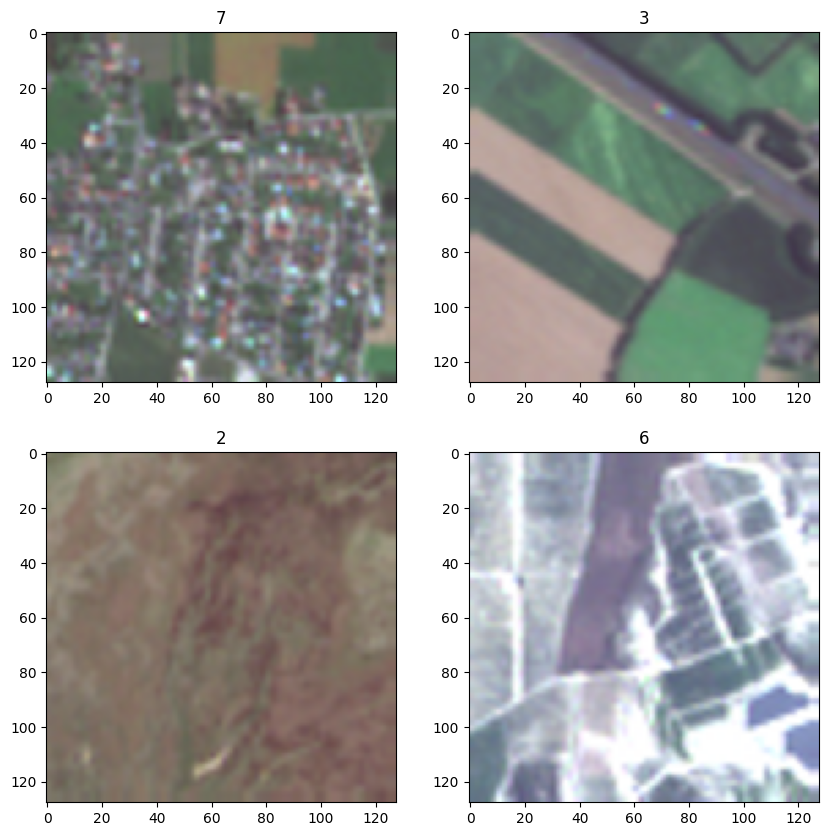

In [20]:
# visualize the dataset via matplotlib
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(dataset["train"][i]['optical'][[3, 2, 1], :, :].permute(1, 2, 0))
    plt.title(dataset["train"][i]['label'])
    # print(torch.max(dataset["train"][i]['optical']))
plt.show()

In [8]:
# len(dataset["train"][0]['optical'][0][0])
dataset['val'][1]

{'optical': tensor([[[0.1933, 0.1933, 0.1932,  ..., 0.2367, 0.2339, 0.2326],
          [0.1934, 0.1933, 0.1932,  ..., 0.2369, 0.2340, 0.2327],
          [0.1934, 0.1934, 0.1933,  ..., 0.2372, 0.2343, 0.2330],
          ...,
          [0.1817, 0.1817, 0.1817,  ..., 0.1771, 0.1771, 0.1771],
          [0.1828, 0.1828, 0.1829,  ..., 0.1771, 0.1771, 0.1771],
          [0.1833, 0.1834, 0.1835,  ..., 0.1771, 0.1771, 0.1771]],
 
         [[0.2160, 0.2162, 0.2164,  ..., 0.2517, 0.2582, 0.2613],
          [0.2161, 0.2162, 0.2165,  ..., 0.2517, 0.2583, 0.2613],
          [0.2162, 0.2163, 0.2166,  ..., 0.2518, 0.2583, 0.2613],
          ...,
          [0.2122, 0.2123, 0.2125,  ..., 0.2123, 0.2176, 0.2201],
          [0.2162, 0.2163, 0.2164,  ..., 0.2087, 0.2179, 0.2223],
          [0.2181, 0.2182, 0.2182,  ..., 0.2070, 0.2181, 0.2233]],
 
         [[0.1546, 0.1544, 0.1542,  ..., 0.2516, 0.2529, 0.2535],
          [0.1544, 0.1543, 0.1540,  ..., 0.2514, 0.2528, 0.2534],
          [0.1542, 0.1540, 0.

In [9]:
dataloader = DataLoader(dataset["val"], batch_size=4, collate_fn=collate_fn)
for i, batch in enumerate(dataloader):
    # print(batch['optical'].shape)
    for key, value in batch.items():
        print(key, value.shape)
    break
labels = batch.pop("labels")

spatial_resolution ()
labels torch.Size([4])
optical torch.Size([4, 13, 128, 128])
optical_channel_wv torch.Size([1, 13])


In [10]:
model = get_task_model(args, metadata["num_classes"], metadata["size"])
if args.pretrained_model_path:
        from safetensors import safe_open
        with safe_open(args.pretrained_model_path, framework="pt", device="cpu") as f:
            # Load only encoder weights
            for key in f.keys():
                if key.startswith("encoder."):
                    # Get the corresponding key in target model
                    param = f.get_tensor(key)
                    model.state_dict()[key].copy_(param)

In [11]:
labels, batch

(tensor([3, 9, 9, 0]),
 {'spatial_resolution': array(5.),
  'optical': tensor([[[[0.6135, 0.6137, 0.6140,  ..., 0.6462, 0.6446, 0.6438],
            [0.6135, 0.6137, 0.6140,  ..., 0.6462, 0.6446, 0.6438],
            [0.6135, 0.6137, 0.6140,  ..., 0.6464, 0.6447, 0.6439],
            ...,
            [0.5748, 0.5749, 0.5749,  ..., 0.5578, 0.5596, 0.5604],
            [0.5787, 0.5788, 0.5789,  ..., 0.5567, 0.5584, 0.5592],
            [0.5806, 0.5806, 0.5807,  ..., 0.5562, 0.5579, 0.5587]],
  
           [[0.5081, 0.5078, 0.5071,  ..., 0.4602, 0.4941, 0.5101],
            [0.5079, 0.5076, 0.5069,  ..., 0.4607, 0.4945, 0.5104],
            [0.5075, 0.5072, 0.5065,  ..., 0.4617, 0.4953, 0.5111],
            ...,
            [0.5898, 0.5890, 0.5873,  ..., 0.5208, 0.5304, 0.5350],
            [0.5272, 0.5226, 0.5126,  ..., 0.5287, 0.5325, 0.5343],
            [0.4977, 0.4912, 0.4774,  ..., 0.5324, 0.5335, 0.5340]],
  
           [[0.4823, 0.4823, 0.4823,  ..., 0.3961, 0.4425, 0.4645],
     

In [12]:
outputs = model.encoder(**batch)

In [14]:
outputs["last_hidden_state"].shape

torch.Size([4, 14, 65, 768])

In [14]:
loss_fn = get_loss_fn(args.task_type)

In [15]:
loss_fn(outputs, labels, None)


tensor(2.8598, grad_fn=<NllLossBackward0>)

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TypeError: Dataset.cleanup_cache_files() missing 1 required positional argument: 'self'

In [3]:
import torch
torch.stack([torch.randn(2, 3, 4)], dim=-1).mean(dim=-1).shape

torch.Size([2, 3, 4])